In [14]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import re
import json
import collections


from util import get_data
from util import mapping
from util import clean_data
from util import config
from util import plot_clusters

import sklearn.cluster
import sklearn.neighbors

In [16]:
# df = pd.read_csv(config.PROCESSED_DATA_PATH + 'trips.csv')
# print(df.shape)
# df = clean_data.filter_cleaned_trips(df)
# print(df.shape)


(4318, 10)


# Trying to make road backbone

In [17]:
# df = pd.read_csv(config.PROCESSED_DATA_PATH + 'trips.csv')
# df = clean_data.filter_cleaned_trips(df)
# # df = df.reset_index(drop=True)
# df.shape
df = pd.read_feather(config.PROCESSED_DATA_PATH + 'trips_culled.feather')
df.set_index('rte_id', inplace=True)
print(df.shape)

(4318, 10)


In [30]:
pts_per_degree = 75
gp, gd = clean_data.make_road_backbone(
    'grid_points_culled_{}'.format(pts_per_degree),
    'rtes_at_grid_culled_{}'.format(pts_per_degree),
     pts_per_degree)
gridpts_at_rte = clean_data.find_gridpts_at_rte(
    gd, 'gridpts_at_rte_culled', pts_per_degree)

Looping through route IDs
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
Total points: 6782


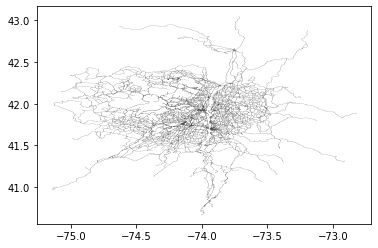

In [33]:
a =  pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_culled_1000.feather')
a.dtypes
gp = pd.read_feather(config.MODEL_PATH + 'grid_points_culled_1000.feather')
plt.plot(gp.lon, gp.lat, 'k.', markersize=0.01)

(41.9, 42.05)

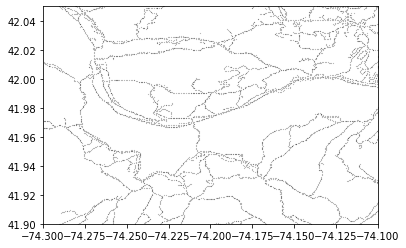

In [20]:

# a = pd.read_feather(config.PROCESSED_DATA_PATH + 'gridpts_at_rte_75.feather')
plt.plot(gp.lon, gp.lat, 'k.', markersize=0.2)
plt.xlim([-74.3, -74.1])
plt.ylim([41.9, 42.05])
# 
# gridpts_at_rte.grid_ids.apply(max).describe()
# gp.shape

In [ ]:
lats = np.linspace(40., 44., 4000)
lons = np.linspace(-76., -72., 4000)
all_lats, all_lons = np.meshgrid(lats, lons)
all_lats = all_lats.flatten().tolist()
all_lons = all_lons.flatten().tolist()
locs = pd.DataFrame({'lat': all_lats, 'lon': all_lons})

In [ ]:
tree = sklearn.neighbors.KDTree(locs)

In [ ]:
a, b = clean_data.initialise_road_backbone_grid()

In [ ]:
gp = clean_data.assign_trip_to_backbone_grid(df.id[10], locs, tree)
gp.breadcrumb_count.sum()
gp.head()
# plt.plot(gp.lon, gp.lat, 'r.')

In [ ]:
#grid_pts, grid_dict = clean_data.make_road_backbone()
grid_pts = pd.read_csv(config.MODEL_PATH + 'road_backbone.csv')
with open(config.MODEL_PATH + 'grid_rte_ids.json', 'r') as fn:
    gd = json.load(fn)
grid_dict = collections.defaultdict(set)
for key in gd:
    grid_dict[int(key)] = set(gd[key])

In [ ]:
type(grid_pts.grid_i.tolist()[0])

In [ ]:
plt.figure(figsize=(10, 10))
grid_pts['n_routes'] = [len(grid_dict[key]) for key in grid_dict]
plt.plot(grid_pts[grid_pts.n_routes > 0].lon, grid_pts[grid_pts.n_routes > 0].lat, 'k.',
            markersize=0.5)
# 41.789, -74.232
plt.ylim(42 + 0.1 * np.array([-1, 1]))
plt.xlim(-74.2 + 0.1 * np.array([-1, 1]))

In [ ]:
grid_pts.head()

In [ ]:
tree2.query(np.array([[41, -74]]), k=1000)

In [ ]:
for i, key in enumerate(grid_dict.keys()):
    if i == 10: break
    print(type(key))
    

In [ ]:
tree2 = sklearn.neighbors.KDTree(grid_pts[['lat', 'lon']])

dict_m = grid_dict.copy()
pts_m = grid_pts.copy().reset_index(drop=True)
for ii, row in pts_m.iterrows():
#     if ii == 5: break
    if not ii % 2000: print(ii)
    if row.breadcrumb_count == 0:
        continue
    res = tree2.query_radius(
        row[['lat', 'lon']].values.reshape(1, -1), r=1/2000
    )
    res = list(res[0])
    res.remove(ii)
    for pt in res:
        id0 = int(pts_m.at[ii, 'grid_i'])
        id1 = int(pts_m.at[pt, 'grid_i'])
#         print(id0, id1, type(id0), type(id1))
        ct0 = pts_m.at[ii, 'breadcrumb_count']
        ct1 = pts_m.at[pt, 'breadcrumb_count']
        if ct1 == 0:
            continue
        pts_m.at[ii, 'lat'] = (
            (pts_m.at[ii, 'lat'] * ct0
             + pts_m.at[pt, 'lat'] * ct1)
            / (ct0 + ct1)
        )
        pts_m.at[ii, 'lon'] = (
            (pts_m.at[ii, 'lon'] * ct0
             + pts_m.at[pt, 'lon'] * ct1)
            / (ct0 + ct1)
        )
        pts_m.at[ii, 'breadcrumb_count'] = ct0 + ct1
        
        dict_m[id0] = dict_m[id0].union(dict_m[id1])
        dict_m[id1] = set()
        
        pts_m.at[ii, 'n_routes'] = len(dict_m[id0])
        
        pts_m.at[pt, 'breadcrumb_count'] = 0

In [ ]:
dict_m[8233796]

In [ ]:
# for key in dd.keys():
#     if key not in gpm.grid_i.tolist():
#         print(key) 
# grid_pts.grid_i.tolist()
# grid_dict[7625740]
# ddkeys = set(dd.keys())
# gpmkeys = set(gpm.grid_i.tolist())
# gpmkeys - ddkeys
gpm[gpm.grid_i == 8233796]

In [ ]:
# grid_dict_merge.delete
gpm = pts_m.copy()
gpm = gpm[gpm.breadcrumb_count > 0]
print(gpm.shape, pts_m.shape)
# plt.figure(figsize=(20,20))
# plt.plot(gpm.lon, gpm.lat, 'k.', markersize=1/1)
# ct0 = grid_pts_merge.iloc[ii]
#row = grid_pts.iloc[2]
# res = tree2.query_radius(
#     row[['lat', 'lon']].values.reshape(1, -1), r=1/2000
# )
# res
# # ls = [len(a) for a in overlaps.values()]
# # overlaps
# a = list(res[0])
# a.remove(2)
# a
print(len(dict_m))
pts_m[pts_m.breadcrumb_count == 0].head()
# if dict_m[8229796]: print('ok')
dd = dict()
print(len(dd))
n = 0
nn = 0
for k, v in dict_m.items():
    nn += 1
    if v:
        n += 1
        dd[k] = v
print(len(dd), n, nn)
# plt.ylim(42 + 0.1 * np.array([-1, 1]))
# plt.xlim(-74.2 + 0.1 * np.array([-1, 1]))

In [ ]:
# grid_pts, grid_dict = clean_data.load_gridpts('road_backbone_coarse', 'grid_rte_ids_coarse')
# clean_data.tidy_road_backbone(grid_pts, grid_dict, 75)
grid_pts, grid_dict = clean_data.make_road_backbone()
# locs, tree = clean_data.initialise_road_backbone_grid(75, True)
# df = pd.read_csv(config.PROCESSED_DATA_PATH + 'trips.csv')
# df = clean_data.filter_cleaned_trips(df)

# grid_pts = pd.DataFrame(columns=['grid_i', 'lat', 'lon', 'breadcrumb_count'])
# grid_dict = collections.defaultdict(set)
# print('Looping through route IDs')
# rte_ids = df['id'].tolist()
# len(rte_ids)

In [ ]:

# grid_dict

# plt.plot(grid_pts.lon, grid_pts.lat, 'r.')
# # plt.plot(locs.loc[grid_pts.grid_i].lon, locs.loc[grid_pts.grid_i].lat, 'k.', markersize=0.5)
# plt.plot(rte.lon, rte.lat, 'k.', markersize=0.5)
# d, i = tree.query(rte[['lat', 'lon']])


In [ ]:
g2.head()

In [ ]:
g2.shape

In [ ]:
# plt.hist(d)
#tree = sklearn.neighbors.KDTree(locs)
g2, gd2 = clean_data.load_gridpts('road_backbone_coarse', 'grid_rte_ids_coarse')
loc_tree = sklearn.neighbors.KDTree(grid_pts[['lat', 'lon']])

In [ ]:
grid_fine = pd.read_csv(config.MODEL_PATH + 'road_backbone_merged.csv')

In [ ]:
tree3 = sklearn.neighbors.KDTree(grid_pts[['lat', 'lon']])

In [ ]:
gpm.to_csv(config.MODEL_PATH + 'road_backbone_merged.csv', index=False)
gd = dict.fromkeys(dd.keys())
for key in gd:
    gd[key] = list(dd[key])
with open(config.MODEL_PATH + 'grid_rte_ids_merged.json', 'w') as fp:
    json.dump(gd, fp)

In [ ]:
    LAT_RANGE = (40., 44.)
    LON_RANGE = (-76., -72.)

    lats = np.linspace(LAT_RANGE[0], LAT_RANGE[1],
                        pts_per_degree * int((np.ptp(LAT_RANGE))))
    lons = np.linspace(LON_RANGE[0], LON_RANGE[1],
                        pts_per_degree * int((np.ptp(LON_RANGE))))
    all_lats, all_lons = np.meshgrid(lats, lons)
    all_lats = all_lats.flatten().tolist()
    all_lons = all_lons.flatten().tolist()
    locs = pd.DataFrame({'lat': all_lats, 'lon': all_lons})


In [ ]:
# plt.plot(grid_fine.lon, grid_fine.lat, 'b.', markersize=0.2)
# plt.plot(locs.lon, locs.lat, 'r.', markersize=0.5)
plt.plot(grid_pts.lon, grid_pts.lat, 'k.', markersize=0.5)
locs.shape

In [ ]:
grid_pts.shape

In [ ]:
dists, inds = tree3.query(np.array([[41, -74.5]]), k=4000)
# dists = dists.flatten()
# inds = inds.flatten()
# inds.shape
# # plt.hist(dists)

In [ ]:
# grid_points, grid_dict = clean_data.load_gridpts('road_backbone_merged', 'grid_rte_ids_merged')
grid_points, grid_dict = clean_data.load_gridpts('road_backbone_coarse', 'grid_rte_ids_coarse')

In [ ]:
keys, vals = rd.items()
pd.DataFrame({'rte_ids': keys, 'grid': vals})

In [ ]:
with open(config.MODEL_PATH + 'rte_dict_fine.json', 'r') as fp:
    rd = json.load(fp)

In [ ]:
with open(config.MODEL_PATH + 'rte_dict_fine.json', 'w') as fp:
    json.dump(rte_dict, fp)

In [ ]:
rte_dict = collections.defaultdict(list)
for grid_id, rte_set in grid_dict.items():
    for rte_id in rte_set:
        rte_dict[rte_id] += [grid_id]



In [ ]:
# print(grid_pts.iloc[inds[0][0]])
qlat = 42
qlon = -74.5

dists, inds = tree3.query(np.array([[qlat, qlon]]), k=4000)

plt.plot(grid_pts.lon, grid_pts.lat, 'k.', markersize=0.5)
plt.plot(qlon, qlat, 'ro', markersize=2)
for i in range(0, 30, 2):
    plt.plot(grid_pts.at[inds[0][i], 'lon'], 
             grid_pts.at[inds[0][i], 'lat'], 'b.')
plt.ylim(qlat + 3 * np.array([-0.5, 0.5]))
plt.xlim(qlon + 3 * np.array([-0.5, 0.5]))

In [ ]:
def calc_dist_point_to_grid(start_lat, start_lon, grid_pts, grid_dict, loc_tree):
    dists, inds = loc_tree.query(np.array([[start_lat, start_lon]]), k=4000)
    dists *= mapping.degrees_to_miles_ish(1)
    rtes_done = set()
    ds = []
    for dist_to_point, i in zip(dists.ravel(), inds.ravel()):
        grid_id = grid_pts.at[i, 'grid_i']
        rtes_at_point = grid_dict[grid_id].copy()
        rtes_at_point -= rtes_done
        ds += [{'dist_to_start': dist_to_point, 'id': rte} for rte in rtes_at_point]
        rtes_done = rtes_done.union(rtes_at_point)

    return pd.DataFrame(ds)

def fit_tree(df, feature_importance):
    LEAF_SIZE = 20
    return sklearn.neighbors.KDTree(df * feature_importance, leaf_size=LEAF_SIZE)

In [ ]:
loc_tree = sklearn.neighbors.KDTree(grid_pts[['lat', 'lon']])
ds = calc_dist_point_to_grid(42, -74.5, grid_pts, grid_dict, loc_tree)

In [ ]:
data = pd.read_csv(config.PROCESSED_DATA_PATH + 'trips.csv', index_col=0)
feature_importance = [1] * data.shape[1]

In [ ]:
data_loc = pd.merge(data, ds, on='id', how='inner')
data_loc = data_loc[data_loc['dist_to_start'] < 10]
data_loc = data_loc.set_index('id')#.drop(['dist_to_start'], axis=1)
data_loc.head()
tree = fit_tree(data_loc, feature_importance + [1])

In [ ]:
dists = data_loc[['dist_to_start']].copy()
dists.iloc[ind[0]]

In [ ]:
chosen = pd.DataFrame([[20, 5, 10., 0.85, 0]], columns=data_loc.columns)
# chosen['dist_to_start'] = 0
N_RIDES = 5

dist, ind = tree.query(chosen, N_RIDES)

In [ ]:
d = data_loc.iloc[ind[0]].copy()
d['dist_to_start'] = dists.iloc[ind[0]]
d

In [ ]:
rtes_done = set()
ds = []
for dist_to_point, i in zip(dists.ravel(), inds.ravel()):
    grid_id = grid_pts.at[i, 'grid_i']
    rtes_at_point = grid_dict[grid_id].copy()
    rtes_at_point -= rtes_done
    ds += [{'dist_to_start': dist_to_point, 'id': rte} for rte in rtes_at_point]
    rtes_done = rtes_done.union(rtes_at_point)

dist_to_start = pd.DataFrame(ds)
dist_to_start['dist_to_start'] *= mapping.degrees_to_miles_ish(1)   
    
    


In [ ]:

dist_to_start.tail()

In [ ]:
dists * mapping.degrees_to_miles_ish(1)

In [ ]:
mapping.degrees_to_miles_ish(1)

In [ ]:
# grid_dict_safe = grid_dict.copy()
print(grid_id)
grid_dict[grid_id]

In [ ]:
dists[0][206]

In [ ]:
i = np.where(dists[0] == dist_to_start.at[2, 'distance'])
grid_id = grid_pts.at[inds[0][i[0][0]], 'grid_i']
print(grid_id)
grid_dict[grid_id]

In [ ]:
dist_to_start.rte_id.shape

In [ ]:
b = set([1])
b.add(1)
b
# j2 = clean_data.add_rte_info_to_grid(gp, a)
# j2.dtypes = ['int', 'float', 'float', 'int']

In [ ]:
a.loc[0] = [8281953, 41, -74, 10]
j = pd.merge(gp, a, on='grid_i', how='outer').fillna(0)
r1_weights = j.breadcrumb_count_x.values
r2_weights = j.breadcrumb_count_y.values
j['lat'] = (j.lat_x * r1_weights + j.lat_y * r2_weights) / (r1_weights + r2_weights)
j['lon'] = (j.lon_x * r1_weights + j.lon_y * r2_weights) / (r1_weights + r2_weights)
j.head()

In [ ]:
d, i = tree.query(res[['lat', 'lon']])

plt.plot(res.lon, res.lat, 'k.')
plt.plot(locs.iloc[np.unique(i)].lon, locs.iloc[np.unique(i)].lat, 'ro')

# i.ravel().tolist()
res['lat_grid'] = locs.iloc[i.ravel()].lat.reset_index(drop=True)
res['lon_grid'] = locs.iloc[i.ravel()].lon.reset_index(drop=True)
res['grid_i'] = i

res.head()

a = res.groupby(['grid_i'])[['lat', 'lon']].agg(['mean', 'count'])
a.columns = ['lat', 'count', 'lon', 'duplicate']
a = a[['lat', 'lon', 'count']]
a.head()
# plt.plot(a.lon, a.lat, 'g*')
# plt.gca().set_aspect('equal')

In [ ]:
grid_pts = pd.DataFrame(columns=['lat', 'lon', 'breadcrumb_count'])
grid_pts

In [ ]:
import joblib
joblib.dump(tree, config.MODEL_PATH + 'kdTree_locs.joblib')

In [ ]:
max_dists = np.array(max_dists)
ind = np.where(max_dists > 0.2)
print(np.where(max_dists[ind] < 0.5))
res = pd.read_csv(config.CLEAN_TRIPS_PATH + '{}.csv'.format(
    df.id.iloc[139]))
plt.plot(res.lon, res.lat)
print(res.dist.max())

In [ ]:
res = pd.read_csv(config.CLEAN_TRIPS_PATH + '{}.csv'.format(df.id[0]))
res.head()
# trip_xy = res.iloc[[0]][['lat', 'lon']]
# plt.plot(trip_xy.x, trip_xy.y, 'k-')
# max_dists = []
# for i, rid in enumerate(df.id.tolist()):
# #     if i == 20: break
#     if not i % 2000: print(i)
#     if not (i + 1) % 10:
#         res = pd.read_csv(config.CLEAN_TRIPS_PATH + '{}.csv'.format(rid))
#         trip_xy = trip_xy.append(res[['lat', 'lon']].iloc[::10])
# #         max_dists += [res.dist.max()]
    
    

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(trip_xy.lon, trip_xy.lat, 'k.', markersize=0.5)

In [ ]:
# for rte_id in df.id.tolist():
#     get_data.ridewithgps_api_trip(rte_id)
rte_id = df[df.labels == 5].id.sample().iloc[0]
print(df[df.id == rte_id].labels.values)
print(trips[trips.id == rte_id][['id', 'distance', 'elevation_gain', 'avg_speed', 'prop_moving', 'duration']])
a = pd.read_csv(config.RAW_TRIPS_PATH + '{}.csv'.format(rte_id))
a.head()

In [ ]:
WINDOW_LENGTH_LATLON = 25
WINDOW_LENGTH_SPEED = 50
WINDOW_LENGTH_ELEVATION = 50

df = a[['y','x','e','t']].dropna().reset_index(drop=True)
df.rename(columns={'y':'lat', 'x':'lon', 'e':'elevation', 't':'time'}, inplace=True)
# df['lat'] = clean_data.moving_window_average(df['lat'], WINDOW_LENGTH_LATLON)
# df['lon'] = clean_data.moving_window_average(df['lon'], WINDOW_LENGTH_LATLON)
# df['elevation'] = clean_data.moving_window_average(df['elevation'], WINDOW_LENGTH_ELEVATION)

# Calculate distance
offset = df.iloc[1:][['lat', 'lon']].copy()
offset = offset.append(offset.iloc[-1])

df.head()

In [ ]:
a = pd.read_csv(config.RAW_TRIPS_PATH + '{}.csv'.format(rte_id))
b = pd.DataFrame()
# if b.empty():#set(['x','y']) - set(a.columns):
#     print('uh oh')
b.empty

# This one below is the cleaning one

In [ ]:
for i, rte_id in enumerate(df.id.tolist()):
    if not i % 100: print(i)
    if os.path.exists(config.CLEAN_TRIPS_PATH + '{}.csv'.format(rte_id)):
        continuea
        
    a = pd.read_csv(config.RAW_TRIPS_PATH + '{}.csv'.format(rte_id))
    c = clean_data.clean_single_trip(a)
    if not c.empty:
        c.to_csv(config.CLEAN_TRIPS_PATH + '{}.csv'.format(rte_id), index=False)

In [ ]:
c = clean_data.clean_single_trip(a)
plt.plot(c.cum_dist, c.speed)
# plt.plot(c.cum_dist, c.slope * 10)
# plt.plot(c.lon, c.lat)

# plt.plot(clean_data.moving_window_average((c.lon +74) * 100, 4))

In [ ]:
df.head()

In [ ]:
plt.plot(c.elevation - b.e)

In [ ]:
b = a[['x', 'y', 'e', 't']].copy()
b['x2'] = a.x[1:].tolist() + [a.iloc[-1].x]
b['y2'] = a.y[1:].tolist() + [a.iloc[-1].y]
b['d'] = mapping.dist_lat_lon(b.y, b.x, b.y2, b.x2)
b['cum_d'] = np.cumsum(b['d'])
b['t'] = (b['t'] - b['t'].min())
b['dt'] = b['t'].diff()
b['slope'] = mapping.metres_to_miles(b.e.diff()) / b.d * 100
b['slope'].fillna(0, inplace=True)
b.at[b['d'] == 0, 'slope'] = 0
b['slope'] = clean_data.moving_window_average(b['slope'], 50)
b['speed_rough'] = b.d / (b['t'].diff() / 60 / 60)
b['speed'] = clean_data.moving_window_average(b['speed_rough'], 50)
plt.plot(np.cumsum(b.d), b.slope)
# plt.plot(b.cum_d, b.speed)
# plt.plot(mapping.metres_to_miles(a.d),mapping.mps_to_mph(a.s), 50)
# plt.xlim([1.5, 1.55])

In [ ]:
# b[b.d < 0.002]['dt'].sum() / 60
# b[1.5 <= b.speed_rough].speed.mean()
b[b.speed_rough < 1.5].dt.sum() / 60 / 60

In [ ]:
clean_data.check_missing(a)

In [ ]:
plt.plot(mapping.metres_to_miles(a['d']), a['s'])
plt.plot(mapping.metres_to_miles(a['d']), a['e'])


In [ ]:
# This doesn't work - more tightly spaced in areas with more points
# res = pd.read_csv(config.CLEAN_TRIPS_PATH + '{}.csv'.format(df.id[0]))
# trip_xy = res[['lat', 'lon']]
BLOB_SPACING_M = 1000
cl = sklearn.cluster.AgglomerativeClustering(n_clusters=None, 
                                             distance_threshold=1/116000*BLOB_SPACING_M)
labels = cl.fit_predict(trip_xy)
print('Clustering done')
n_labels = len(np.unique(labels))
cluster_centres = np.zeros((n_labels, 2))
for i, lab in enumerate(np.unique(labels)):
    cluster_centres[i, 0] = trip_xy[labels == lab].lat.mean()
    cluster_centres[i, 1] = trip_xy[labels == lab].lon.mean()
    
    

In [ ]:
plt.figure(figsize=(15, 15))
plt.plot(trip_xy.lon, trip_xy.lat, 'k.', markersize=0.5)
# plt.plot(cl.cluster_centers_[:, 0], cl.cluster_centers_[:, 1], 'ro')
# plt.plot(cluster_centres[:, 1], cluster_centres[:, 0], 'ro')
# plt.xlim([-73.94, -73.92])
# plt.ylim([41.75, 41.825])